In [1]:
write = True # log this version as new
MODEL_DESCRIPTION = "Dense Only"

In [2]:
import os
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sys import stdout
from datetime import datetime
import neptune as neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback
from astropy.io import fits
import random
from DataMaker import HDF5ImageGenerator

2023-05-08 01:31:17.918256: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 01:31:18.416950: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/billyli/miniconda3/lib/python3.9/site-packages/neptune_tensorflow_keras/impl/__init__.py:44: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  from neptune.new import Run


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from tensorflow.keras.layers import Cropping2D, ZeroPadding2D, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
import tensorflow_probability as tfp
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tensorflow.nn import leaky_relu
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

In [4]:
LATENT_DIM = 128
BASE_DEPTH = 8
IMAGE_SHAPE = (5, 127, 127)
BATCH_SIZE = 512
EPOCHS = 250
CHECKPOINTS_TO_SAVE = 4
KL_WEIGHT = 1e-6
# Good value: 1e-6
# With KL 0 val_loss = 0.4763
# With KL 1e-6 val loss = 1.0732
# With KL 1e-8 val loss = 0.5257
# With KL 1e-10 val loss = 0.4466 0.4291

In [5]:
gpus = tf.config.list_physical_devices('GPU');
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)]);
        logical_gpus = tf.config.experimental.list_logical_devices('GPU');
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


2023-05-08 01:31:20.276938: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-08 01:31:20.296790: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-08 01:31:20.296991: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
now = datetime.now()

DATASET_NAME = "HSC_v6"
MODEL_TYPE = "CVAE"
MODEL_VERSION = "v1.0"
MODEL_SUBVERSION = "v1.0." + now.strftime("%Y%m%d_%H_%M_%S")

model_id = '_'.join([DATASET_NAME, MODEL_TYPE, MODEL_VERSION])
model_path = os.path.join('/data3/Billy/models', model_id, MODEL_SUBVERSION, 'model')
checkpoints_path = os.path.join('/data3/Billy/models', model_id, MODEL_SUBVERSION, 'checkpoints')
logs_path = os.path.join('/data3/Billy/logs', model_id, MODEL_SUBVERSION)
predictions_path = os.path.join('/data3/Billy/predictions', model_id, MODEL_SUBVERSION)
weights_path = model_path + '/data3/Billy/CVAE/weights.h5'

os.makedirs(model_path, exist_ok = True)
os.makedirs(checkpoints_path, exist_ok = True)
os.makedirs(logs_path, exist_ok = True)
os.makedirs(predictions_path, exist_ok = True)

if write == True:
    with open("/data3/Billy/models/README.md", "a") as myfile:
        myfile.write(MODEL_TYPE + " " + MODEL_SUBVERSION + " - " + MODEL_DESCRIPTION + " - B. Li" + "\n")
else:
    with open("/data3/Billy/models/README.md", "a") as myfile:
        myfile.write(MODEL_TYPE + " " + MODEL_SUBVERSION + " - ... "+ " - B. Li" + "\n")

In [7]:
args_gen = {'X_key': 'image',
    'y_key': 'specz_redshift',
    'scaler': False,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'mode': 'train',
    'shuffle': False}

train_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step2A/127x127/5x127x127_training.hdf5', **args_gen)
val_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step2A/127x127/5x127x127_validation.hdf5', **args_gen)
test_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step2A/127x127/5x127x127_testing.hdf5', **args_gen)

In [8]:
n = BATCH_SIZE
l = len(train_gen._indices)

In [9]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(LATENT_DIM), scale = 0.1), reinterpreted_batch_ndims = 1)

images = Input(shape = IMAGE_SHAPE)
conv1 = Conv2D(5, 1, strides = 1, activation = None, 
           padding = 'valid', data_format = 'channels_first')(images)
flatten = Flatten()(conv1)
redshifts = Input(shape = 1,)
dense1 = Dense(1024, activation = None)(flatten)
dense2 = tf.keras.layers.Dense(128, activation = "relu")(redshifts)
dense3 = tf.keras.layers.Dense(128, activation = "relu")(dense2)
concat = tf.keras.layers.Concatenate()([dense1, dense3])
dense4 = Dense(tfpl.MultivariateNormalTriL.params_size(LATENT_DIM), activation = None)(concat)
z = tfpl.MultivariateNormalTriL(LATENT_DIM,
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight = KL_WEIGHT))(dense4)
encoder = Model([images, redshifts], z)

zc = tf.keras.layers.Concatenate()([z, redshifts])

# encoder.summary()

In [10]:
dense5 = Dense(1024, activation = None)
dense6 = Dense(5 * 127 * 127, activation = None)
outputs = Reshape(IMAGE_SHAPE)

In [11]:
dense5_model = dense5(zc)
dense6_model = dense6(dense5_model)
outputs_model = outputs(dense6_model)

In [12]:
model = Model(inputs = [images, redshifts], outputs = [outputs_model])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 127, 127  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 5, 127, 127)  30          ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 flatten (Flatten)              (None, 80645)        0           ['conv2d[0][0]']           

In [13]:
latents = Input(shape = (LATENT_DIM + 1, ))
dense5_decoder = dense5(latents)
dense6_decoder = dense6(dense5_decoder)
outputs_decoder = outputs(dense6_decoder)

In [14]:
decoder = Model(latents, outputs_decoder)

In [15]:
optimizer = Adam(learning_rate = 0.0001)
model.compile(optimizer = optimizer, loss = 'mse')

In [16]:
run = neptune.init_run(
    name = MODEL_SUBVERSION,
    project = "astro-data-lab/VAE",
    api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxOGFlZGMxOC04MWU5LTQ2NDctYjlhZS05NGE2NGQ0NmIzMmEifQ==",
)  # your credentials

# logs_callback = TensorBoard(log_dir = logs_path)

weights_callback = ModelCheckpoint(filepath = os.path.join(checkpoints_path, 'weights_epoch{epoch}.hdf5'), save_freq = int(EPOCHS/CHECKPOINTS_TO_SAVE), save_weights_only = True)

LR_callback = ReduceLROnPlateau()

def scheduler(epoch, lr):
    if epoch <= 100:
        return lr
    else:
        return lr / 10

LR_modify_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 0)

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs_path, histogram_freq = 1)

neptune_callback = NeptuneCallback(run = run)

/tmp/ipykernel_3412052/1874926983.py:1: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/astro-data-lab/VAE/e/VAE-144


In [17]:
train_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step2A/127x127/5x127x127_training.hdf5', **args_gen)

In [18]:
history = model.fit(train_gen, epochs = 150, callbacks = [neptune_callback], validation_data = val_gen, verbose = 1)

Epoch 1/150


/home/billyli/miniconda3/lib/python3.9/site-packages/keras/callbacks.py:530: NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'NoneType'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
  callback.on_train_begin(logs)
2023-05-08 01:31:24.537443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-08 01:31:26.978721: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023

392/392 [==============================] - ETA: 0s - loss: 4.5437

2023-05-08 01:36:20.529106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


392/392 [==============================] - 367s 926ms/step - loss: 4.5437 - val_loss: 4.2942
Epoch 2/150
392/392 [==============================] - 367s 935ms/step - loss: 4.6570 - val_loss: 4.1379
Epoch 3/150
392/392 [==============================] - 351s 896ms/step - loss: 4.9803 - val_loss: 4.2019
Epoch 4/150
392/392 [==============================] - 342s 873ms/step - loss: 5.0505 - val_loss: 4.2796
Epoch 5/150
392/392 [==============================] - 352s 897ms/step - loss: 5.2029 - val_loss: 4.0317
Epoch 6/150
392/392 [==============================] - 351s 895ms/step - loss: 5.4890 - val_loss: 3.8016
Epoch 7/150
392/392 [==============================] - 361s 921ms/step - loss: 5.0562 - val_loss: 3.6166
Epoch 8/150
392/392 [==============================] - 354s 902ms/step - loss: 5.0685 - val_loss: 3.6174
Epoch 9/150
392/392 [==============================] - 354s 904ms/step - loss: 4.6705 - val_loss: 3.4101
Epoch 10/150
392/392 [==============================] - 356s 910ms/

In [19]:
# train_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step3/5x127x127_training_min_3.hdf5', **args_gen)

In [20]:
# history = model.fit(train_gen, epochs = 75, callbacks = [neptune_callback], validation_data = val_gen, verbose = 1)

In [21]:
# train_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step3/5x127x127_training_min_2.hdf5', **args_gen)

In [22]:
# history = model.fit(train_gen, epochs = 100, callbacks = [weights_callback, neptune_callback], validation_data = val_gen, verbose = 1)

In [23]:
# train_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step3/5x127x127_training_min_1.hdf5', **args_gen)

In [24]:
# history = model.fit(train_gen, epochs = 100, callbacks = [weights_callback, neptune_callback], validation_data = val_gen, verbose = 1)

In [25]:
# train_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step2A/127x127/5x127x127_training.hdf5', **args_gen)

In [26]:
# history = model.fit(train_gen, epochs = 100, callbacks = [neptune_callback, LR_callback], validation_data = val_gen, verbose = 1)

In [50]:
# model.save_weights(weights_path)

In [51]:
# model.load_weights(weights_path)

z = 0.085649997


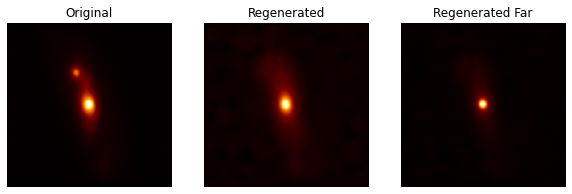

In [28]:
lib = 3
index = 466
z = test_gen[lib][0][1][index]
z_shifted = 4
band = 0
print(f'z = {z}')
str = np.asarray(encoder([np.array([test_gen[lib][0][0][index]]), np.array([test_gen[lib][0][1][index]])])[0])
str = np.concatenate((str, np.array([z])))
str = str.reshape(1, LATENT_DIM + 1)
str_shifted = np.asarray(encoder([np.array([test_gen[lib][0][0][index]]), np.array([test_gen[lib][0][1][index]])])[0])
str_shifted = np.concatenate((str_shifted, np.array([z_shifted])))
str_shifted = str_shifted.reshape(1, LATENT_DIM + 1)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 5))
axes[0].imshow(test_gen[lib][0][0][index][band], cmap = 'afmhot')
axes[1].imshow(decoder([str])[0][band], cmap = 'afmhot')
axes[2].imshow(decoder([str_shifted])[0][band], cmap = 'afmhot')
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[0].set_title("Original")
axes[1].set_title("Regenerated")
axes[2].set_title("Regenerated Far")
plt.show()

z = 3.83520007


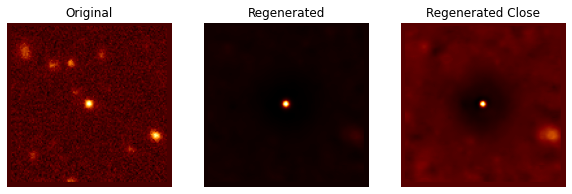

In [49]:
lib = 5
index = 271
z = test_gen[lib][0][1][index]
z_shifted = 3.5
band = 0
print(f'z = {z}')
str = np.asarray(encoder([np.array([test_gen[lib][0][0][index]]), np.array([test_gen[lib][0][1][index]])])[0])
str = np.concatenate((str, np.array([z])))
str = str.reshape(1, LATENT_DIM + 1)
str_shifted = np.asarray(encoder([np.array([test_gen[lib][0][0][index]]), np.array([test_gen[lib][0][1][index]])])[0])
str_shifted = np.concatenate((str_shifted, np.array([z_shifted])))
str_shifted = str_shifted.reshape(1, LATENT_DIM + 1)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 5))
axes[0].imshow(test_gen[lib][0][0][index][band], cmap = 'afmhot')
axes[1].imshow(decoder([str])[0][band], cmap = 'afmhot')
axes[2].imshow(decoder([str_shifted])[0][band], cmap = 'afmhot')
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[0].set_title("Original")
axes[1].set_title("Regenerated")
axes[2].set_title("Regenerated Close")
plt.show()

In [ ]:
band = 0
str = prior.sample(1)[0]
strlo = np.concatenate((str, np.array([0.1])))
strlo = strlo.reshape(1, LATENT_DIM + 1)
strhi = np.concatenate((str, np.array([4])))
strhi = strhi.reshape(1, LATENT_DIM + 1)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
axes[0].imshow(decoder([strlo])[0][band], cmap = 'afmhot')
axes[1].imshow(decoder([strhi])[0][band], cmap = 'afmhot')
axes[0].axis('off')
axes[1].axis('off')
axes[0].set_title("Low z")
axes[1].set_title("High z")
plt.show()

In [ ]:
print(str)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
x_array = np.arange(5)
lo_array = np.array([])
hi_array = np.array([])
for j in range(0, 5):
    lo_array = np.append(lo_array, decoder([strlo])[0][j][63][63])
    hi_array = np.append(hi_array, decoder([strhi])[0][j][63][63])
axes[0].scatter(x_array, lo_array, c = 'blue', label = 'Low')
axes[1].scatter(x_array, hi_array, c = 'red', label = 'High')
axes[0].set_xlabel("Bands")
axes[0].set_ylabel("Central Pixel Value")
axes[0].legend()
axes[1].legend()

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
x_array = np.arange(5)
lo_array = np.array([])
hi_array = np.array([])
for j in range(0, 5):
    lo_array = np.append(lo_array, np.amax(np.transpose(np.asarray(decoder([strlo])[0][j][60:67]))[60:67].flatten()))
    hi_array = np.append(hi_array, np.amax(np.transpose(np.asarray(decoder([strhi])[0][j][60:67]))[60:67].flatten()))
axes.scatter(x_array, lo_array, c = 'blue', label = 'Low')
axes.scatter(x_array, hi_array, c = 'red', label = 'High')
axes.set_xlabel("Bands")
axes.set_ylabel("Max Pixel Value Near Center")
axes.legend()
axes.legend()

for j in range(3, 80):
    for i in range(0, 512):
        if test_gen[j][0][1][i] <= 0.1:
            print(j)
            print(i)

for j in range(3, 80):
    for i in range(0, 512):
        if test_gen[j][0][1][i] >= 3.5:
            print(j)
            print(i)

for i in range(0, 84):
    l = 512
    if i == 83:
        l = 464
    for j in range(0, l):
        index = i * BATCH_SIZE + j + 1
        stdout.write("\rChecking %d samples of " % (index) + "42960")
        z = test_gen[i][0][1][j]
        str = np.asarray(encoder([np.array([test_gen[i][0][0][j]]), np.array([test_gen[i][0][1][j]])])[0])
        str = np.concatenate((str, np.array([z])))
        str = str.reshape(1, LATENT_DIM + 1)
        hdul = fits.PrimaryHDU(data = test_gen[i][0][0][j])
        string = f"/data/CVAE Generated/Full/Original Galaxy #{index}.fits"
        hdul.writeto(string, overwrite = True)
        hdul = fits.PrimaryHDU(data = decoder([str])[0])
        string = f"/data/CVAE Generated/Full/Reconstructed Galaxy #{index}.fits"
        hdul.writeto(string, overwrite = True)

In [30]:
def scatter_bands_max_near_center(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show / 5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_array = np.append(true_array, np.amax(np.array([test_gen[0][0][0][i][j]])))
            pred_array = np.append(pred_array, np.amax(np.transpose(np.asarray(model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j][60:67]))[60:67].flatten()))
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_xlabel("Bands")
        axes[int((i - index) / 5)][int((i - index) % 5)].set_ylabel(f"Maximum normalized pixel value z = {np.array([test_gen[0][0][1][i]])[0]}")
        axes[int((i - index) / 5)][int((i - index) % 5)].legend()

def scatter_bands_max(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show / 5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_array = np.append(true_array, np.amax(np.array([test_gen[0][0][0][i][j]])))
            pred_array = np.append(pred_array, np.amax(np.array([model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j]])))
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_xlabel("Bands")
        axes[int((i - index) / 5)][int((i - index) % 5)].set_ylabel("Maximum normalized pixel value")
        axes[int((i - index) / 5)][int((i - index) % 5)].legend()
        
def scatter_bands_center(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show / 5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_array = np.append(true_array, np.array([test_gen[0][0][0][i][j]])[0][63][63])
            pred_array = np.append(pred_array, model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j][63][63])
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_xlabel("Bands")
        axes[int((i - index) / 5)][int((i - index) % 5)].set_ylabel(f"Central pixel value z = {np.array([test_gen[0][0][1][i]])}")
        axes[int((i - index) / 5)][int((i - index) % 5)].legend()
        
def scatter_bands_center_shift(lib = 3, i = 37, z = 1):
    print(z)
    fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
    x_array = np.arange(5)
    true_array = np.array([])
    pred_array = np.array([])
    for j in range(0, 5):
        true_array = np.append(true_array, np.array([test_gen[lib][0][0][i][j]])[0][63][63])
        pred_array = np.append(pred_array, model([np.array([test_gen[lib][0][0][i]]), np.array([z])])[0][j][63][63])
    axes.scatter(x_array, true_array, c = 'blue', label = 'True')
    axes.scatter(x_array, pred_array, c = 'red', label = 'Predicted')
    axes.set_xlabel("Bands")
    axes.set_ylabel("Central pixel value")
    axes.legend()
    
def scatter_bands_max_shift(lib = 3, i = 37, z = 1):
    print(z)
    fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
    x_array = np.arange(5)
    true_array = np.array([])
    pred_array = np.array([])
    for j in range(0, 5):
        true_array = np.append(true_array, np.amax(np.array([test_gen[lib][0][0][i][j]])))
        pred_array = np.append(pred_array, np.amax(np.array([model([np.array([test_gen[lib][0][0][i]]), np.array([z])])[0][j]])))
    axes.scatter(x_array, true_array, c = 'blue', label = 'True')
    axes.scatter(x_array, pred_array, c = 'red', label = 'Predicted')
    axes.set_xlabel("Bands")
    axes.set_ylabel("Central pixel value")
    axes.legend()

def scatter_bands_percentile(percentile = 90, num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show /  5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_90 = np.percentile(np.array([test_gen[0][0][0][i][j]]).flatten(), percentile)
            pred_90 = np.percentile(np.asarray(model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j]).flatten(), percentile)
            true_array = np.append(true_array, true_90)
            pred_array = np.append(pred_array, pred_90)
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_xlabel('Bands')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_ylabel(f'{percentile}th percentile normalized pixel value')
        axes[int((i - index) / 5)][int((i - index) % 5)].legend()

def scatter_bands_mean(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show / 5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_mean = np.mean(np.array([test_gen[0][0][0][i][j]]).flatten())
            pred_mean = np.mean(np.asarray(model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j]).flatten())
            true_array = np.append(true_array, true_mean)
            pred_array = np.append(pred_array, pred_mean)
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_xlabel('Bands')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_ylabel('Mean normalized pixel value')
        axes[int((i - index) / 5)][int((i - index) % 5)].legend()

def display_histograms(num_to_show = 2, index = 0):
    fig, axes = plt.subplots(nrows = num_to_show, ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        for j in range(0, 5):
            true_arr = sorted(np.array([test_gen[0][0][0][i][j]]).flatten())
            pred_arr = sorted(np.asarray(model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j]).flatten())
            true_arr = true_arr[0 : int(len(true_arr) * .99)]
            pred_arr = pred_arr[0 : int(len(pred_arr) * .99)]
            axes[i][j].hist(true_arr, 100, color = 'blue', label = 'True', alpha = 0.5)
            axes[i][j].hist(pred_arr, 100, color = 'red', label = 'Predicted', alpha = 0.5)
            axes[i][j].set_xlabel("Pixel Values")
            axes[i][j].set_ylabel("Count")
            axes[i][j].legend()
    fig.suptitle('Histograms of Predicted vs. True Image, Horizontal are Bands')
    
def display_5_bands(index):
    fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (20, 10))
    loss = round(model.evaluate([np.array([test_gen[0][0][0][index]]), np.array([test_gen[0][0][1][index]])], np.array([test_gen[0][0][0][index]]), verbose = 0), 2)
    for i in range(0, 5):
        axes[0][i].imshow(np.array([test_gen[0][0][0][index]])[0][i], cmap = 'afmhot')
        max_pixel_true = round(np.amax(np.array([test_gen[0][0][0][index]])[0][i]), 2)
        # axes[0][i].set_title(f'True band {i} max = {max_pixel_true}')
        pred = model([np.array([test_gen[0][0][0][index]]), np.array([test_gen[0][0][1][index]])])[0][i]
        axes[1][i].imshow(pred, cmap = 'afmhot')
        max_pixel_pred = round(np.amax(pred), 2)
        axes[1][i].set_title(f'\n loss = {loss}') # f'Pred band {i} max = {max_pixel_pred}' + 
        
def display_high_loss(num_to_show, min_loss):
    fig, axes = plt.subplots(nrows = num_to_show, ncols = 5, figsize = (20, 5 * num_to_show))
    r = 0
    for i in range(BATCH_SIZE):
        loss = round(model.evaluate([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])], np.array([test_gen[0][0][0][i]]), verbose = 0), 2)
        if loss >= min_loss:
            print(i)
            for j in range(0, 5):
                axes[r][j].imshow(np.array([test_gen[0][0][0][i]])[0][j], cmap = 'afmhot')
                axes[r][j].set_title(f'Loss = {loss}')
            r += 1
        if r >= num_to_show:
            break

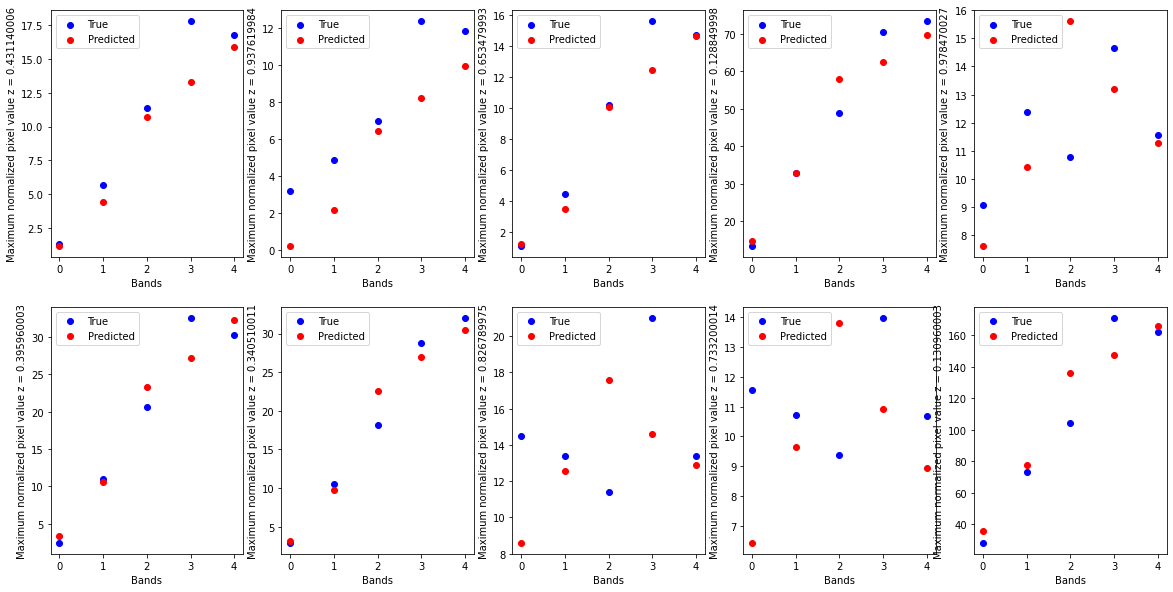

In [31]:
scatter_bands_max_near_center(num_to_show = 10, index = 10)

512


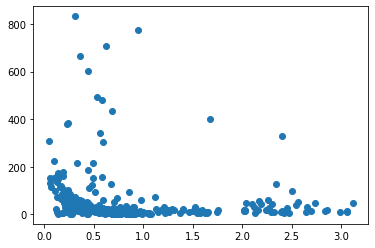

In [34]:
x_array = np.array([])
y_array = np.array([])
l = len(test_gen[0][0][0])
print(l)
for i in range(0, l):
    x_array = np.append(x_array, np.amax(np.array([test_gen[0][0][0][i][4]])))
    y_array = np.append(y_array, np.array([test_gen[0][0][1][i]])[0])
    # print(i)
plt.scatter(y_array, x_array)

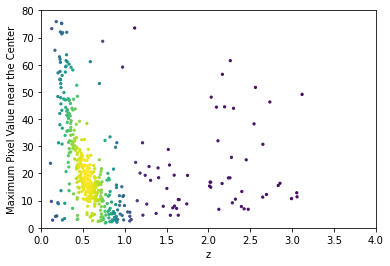

In [35]:
from scipy.stats import gaussian_kde
xy = np.asarray(np.vstack([y_array, x_array])).astype('float32')
z = gaussian_kde(xy)(xy)
plt.scatter(y_array, x_array, s = 5, c = z)
plt.xlim(0,4)
plt.ylim(0, 80)
plt.xlabel("z")
plt.ylabel("Maximum Pixel Value near the Center")
plt.show()

40


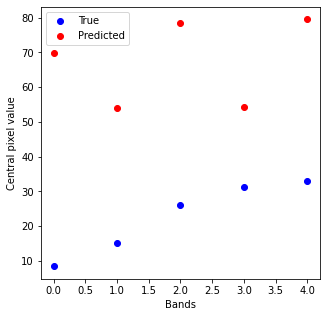

In [36]:
scatter_bands_center_shift(lib = 3, i = 267, z = 40)

3.99530005


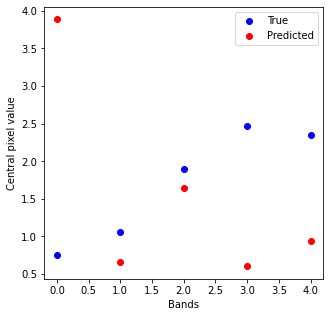

In [37]:
scatter_bands_max_shift(lib = 3, i = 37, z = test_gen[3][0][1][37])

0.1


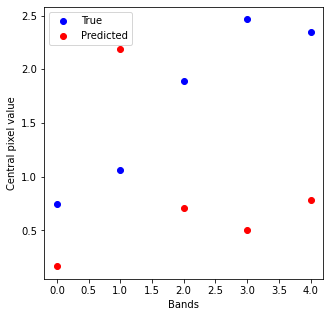

In [38]:
scatter_bands_max_shift(lib = 3, i = 37, z = 0.1)

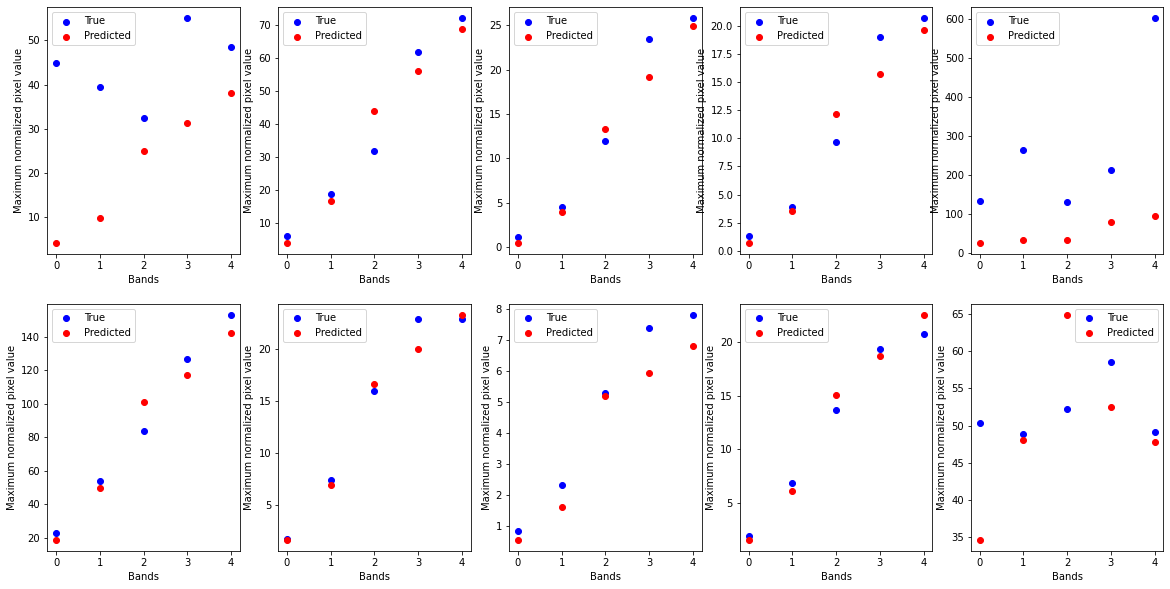

In [39]:
scatter_bands_max()

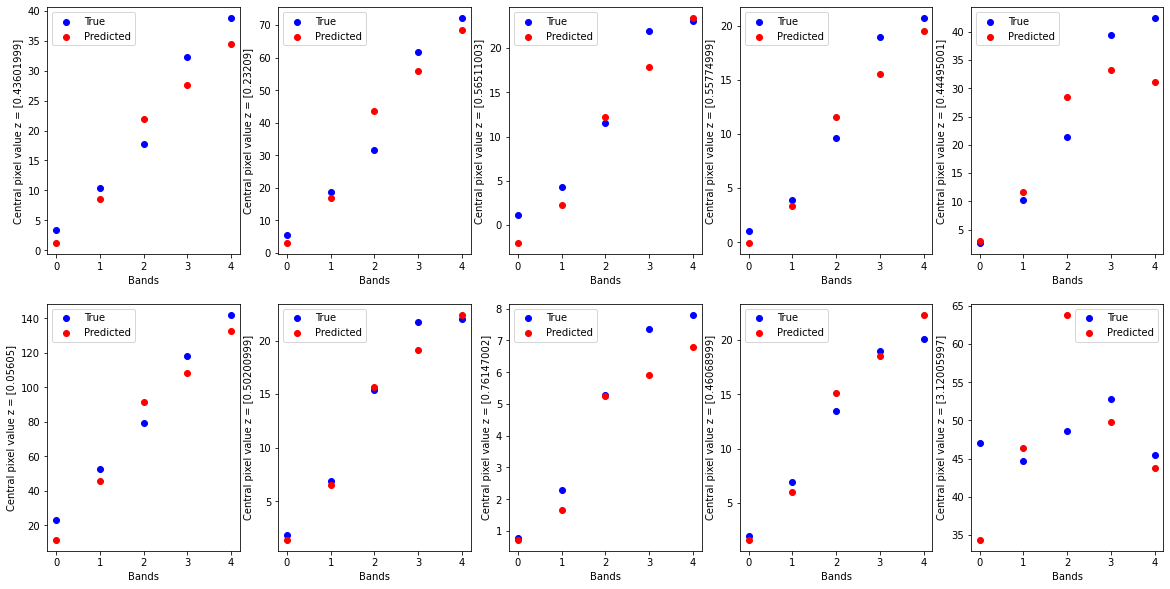

In [40]:
scatter_bands_center()

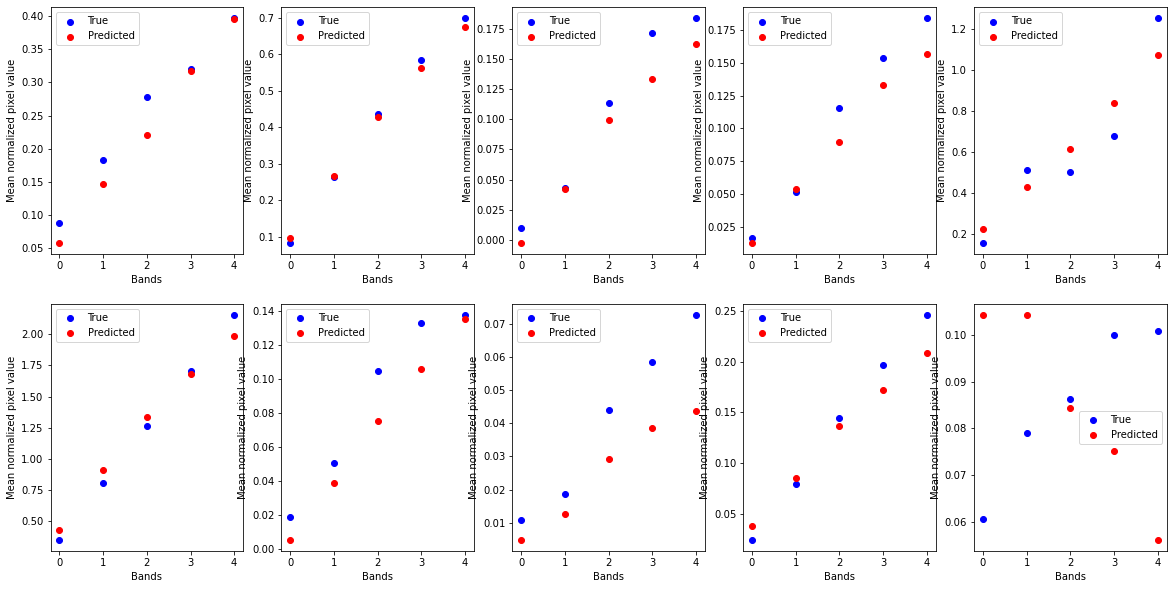

In [41]:
scatter_bands_mean(10, 0)

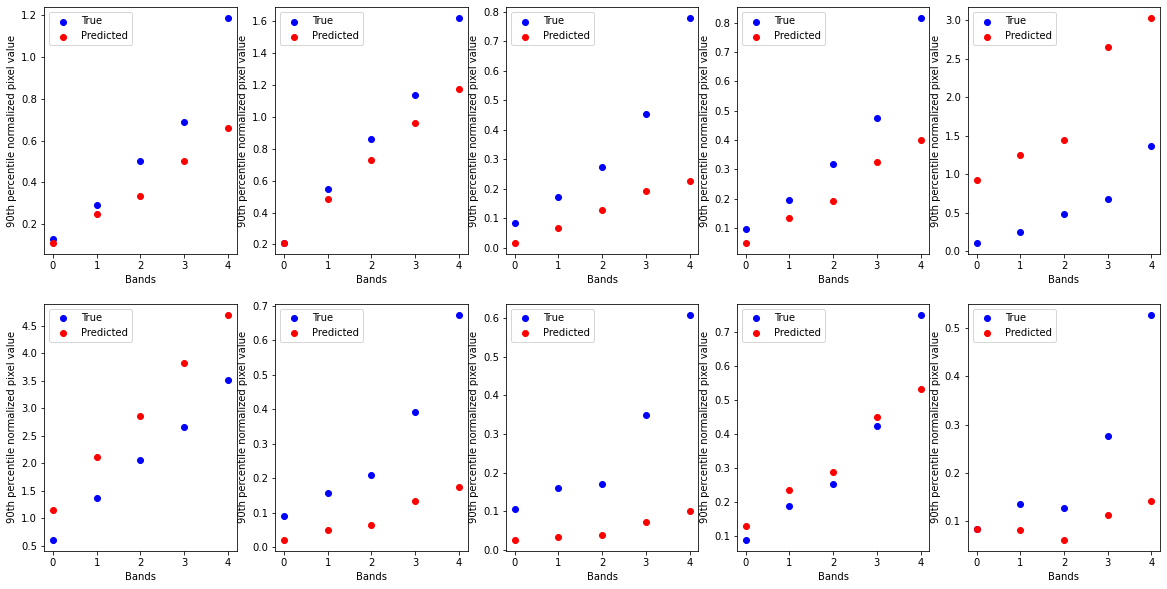

In [42]:
scatter_bands_percentile()

In [43]:
# display_histograms()

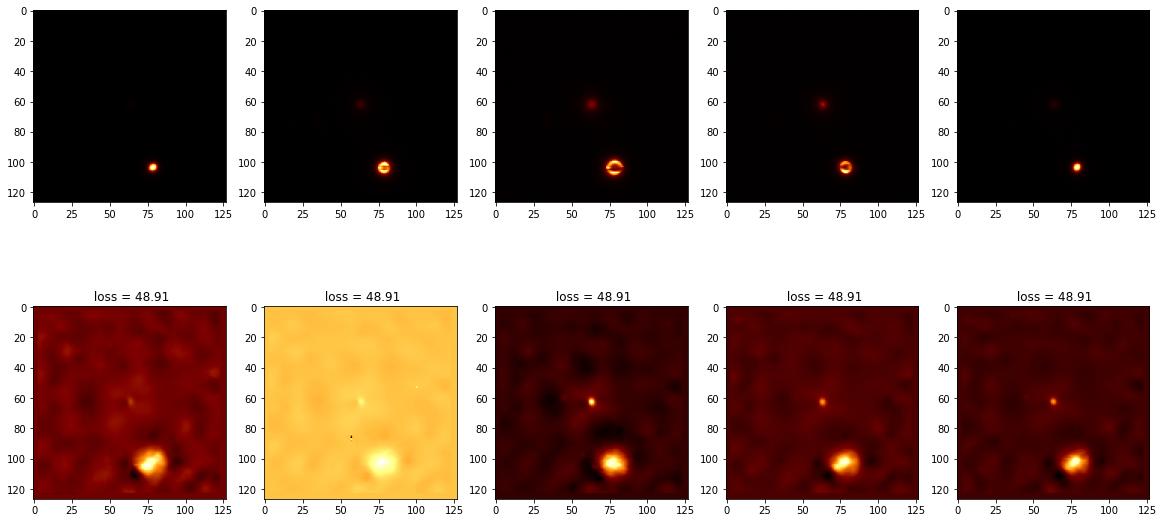

In [44]:
display_5_bands(38)

4
5
34
36
38
40
41
83
104
121


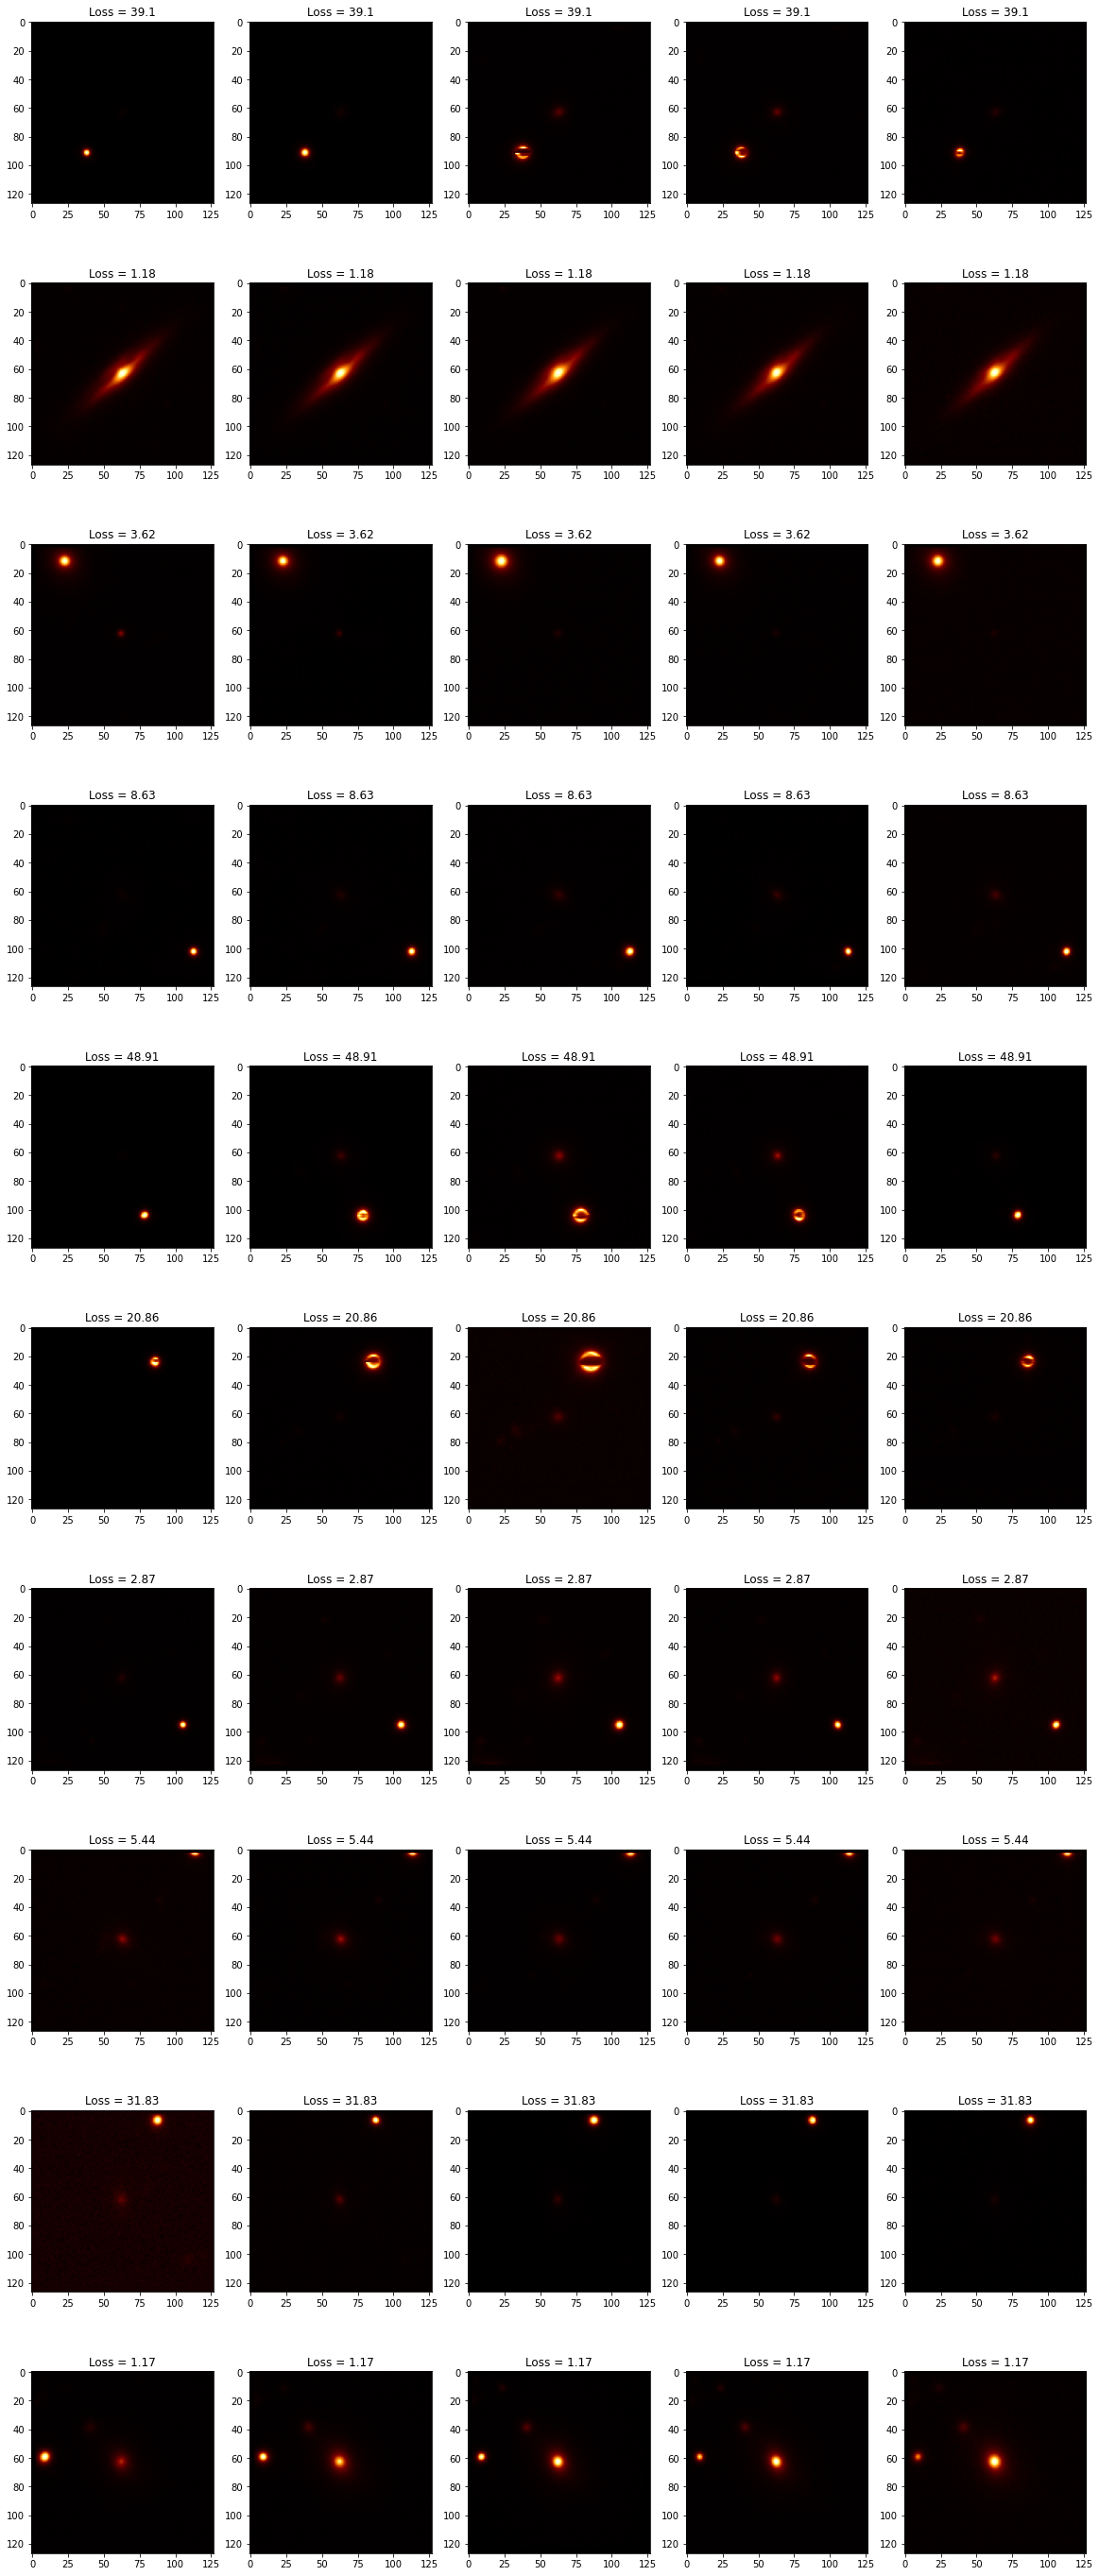

In [45]:
display_high_loss(10, 1)

In [54]:
hf = h5py.File('/data/HSC/HSC_v6/step3/127x127_generated.hdf5', 'a')
prior1 = tfd.Independent(tfd.Normal(loc=tf.zeros(LATENT_DIM), scale = 0.1), reinterpreted_batch_ndims = 1)
str = prior1.sample(1)[0]
str = np.concatenate((str, np.array([0.1])))
str = str.reshape(1, LATENT_DIM + 1)
image_g = decoder([str])[0][0]
image_r = decoder([str])[0][1]
image_i = decoder([str])[0][2]
image_z = decoder([str])[0][3]
image_y = decoder([str])[0][4]
five_band_image = []
five_band_image.append(image_g)
five_band_image.append(image_r)
five_band_image.append(image_i)
five_band_image.append(image_z)
five_band_image.append(image_y)
five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 127, 127])
hf.create_dataset('image', data = five_band_image_reshape, chunks = True, maxshape = (None, 5, 127, 127))
hf.create_dataset('specz_redshift', data = [0.1], chunks = True, maxshape = (None, ))
for i in range(9999):
    z = random.uniform(0, 4)
    str = prior.sample(1)[0]
    str = np.concatenate((str, np.array([z])))
    str = str.reshape(1, LATENT_DIM + 1)
    image_g = decoder([str])[0][0]
    image_r = decoder([str])[0][1]
    image_i = decoder([str])[0][2]
    image_z = decoder([str])[0][3]
    image_y = decoder([str])[0][4]
    five_band_image = []
    five_band_image.append(image_g)
    five_band_image.append(image_r)
    five_band_image.append(image_i)
    five_band_image.append(image_z)
    five_band_image.append(image_y)
    five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 127, 127])
    hf['specz_redshift'].resize((hf['specz_redshift'].shape[0] + 1), axis = 0)
    hf['specz_redshift'][hf['specz_redshift'].shape[0] - 1] = [z]
    hf['image'].resize((hf['image'].shape[0] + 1), axis = 0)
    hf['image'][hf['image'].shape[0] - 1, :, :, :] = five_band_image
hf.close()

In [ ]:
# END